In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from scipy.ndimage import gaussian_filter1d
from pyonset import Onset, BootstrapWindow
from anisotropy import run_SEPevent

In [55]:
data_path = f"{os.getcwd()}{os.sep}data"

onset_date = pd.to_datetime("2021-10-28")
start = onset_date - pd.Timedelta(days=1)
end = onset_date + pd.Timedelta(days=2)    # off by one, so three days are loaded now

event = run_SEPevent(data_path, spacecraft_instrument="Wind 3DP", starttime=start, endtime=end, species="e", channels=3, averaging="15min")

Input was Wind, using Wind.
Spacecraft: Wind
Instrument: 3DP. Species: e. Channels: 3.


15-Nov-25 00:55:16: File is current: /home/osant/gradu/data/wind_masters/wi_h0_mfi_00000000_v01.cdf
15-Nov-25 00:55:16: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h0/2021/
15-Nov-25 00:55:17: File is current: /home/osant/gradu/data/mfi/mfi_h0/2021/wi_h0_mfi_20211027_v05.cdf
15-Nov-25 00:55:17: File is current: /home/osant/gradu/data/mfi/mfi_h0/2021/wi_h0_mfi_20211028_v05.cdf
15-Nov-25 00:55:17: File is current: /home/osant/gradu/data/mfi/mfi_h0/2021/wi_h0_mfi_20211029_v05.cdf


(<Figure size 800x500 with 5 Axes>,
 array([<Axes: title={'center': 'Wind'}>,
        <Axes: ylabel='Pitch angle [$\\degree$]'>,
        <Axes: xlabel='Universal Time (UT)', ylabel='Intensity\n [1/(s$\\,$cm²$\\,$sr$\\,$MeV)]'>],
       dtype=object))

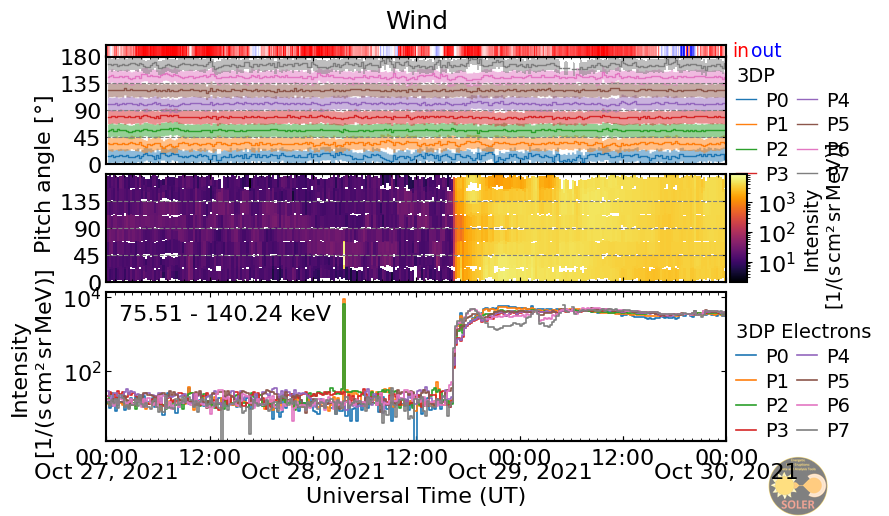

In [56]:
event.overview_plot()

Idea: do Gaussian kernel smoothing on 15 minutes downsampled data. Find local optima of the time-series (look at where discrete difference changes signs). If consecutive optima with positive difference are an order of magnitude apart -> identify approximate onset there. Then do Poisson-CUSUM with 8 hrs initial background to get a better estimate of the onset. (Could consider hybrid method if computationally feasible but only an approximate one is needed, so this is easier)

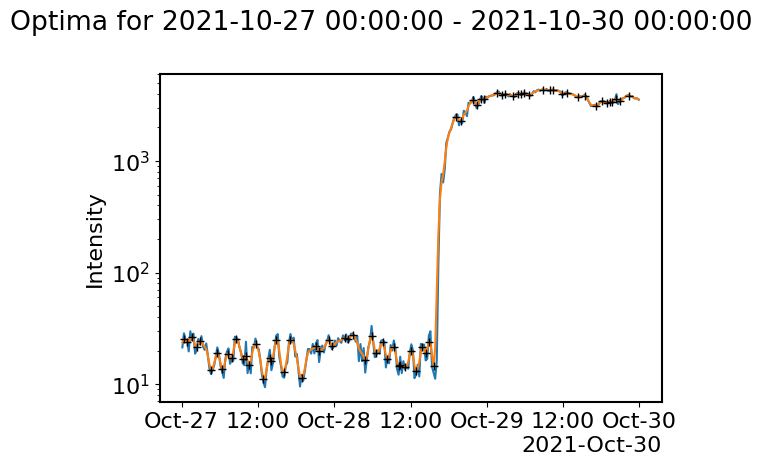

In [57]:
data = pd.Series(event.I_data[:,3], index=event.I_times)
smooth = gaussian_filter1d(data, sigma=1)
smooth_diff = np.diff(smooth)
arg_optima = []
for i in range(len(smooth_diff)-1):
    if (smooth_diff[i + 1] > 0 and smooth_diff[i] < 0) or (smooth_diff[i + 1] < 0 and smooth_diff[i] > 0):
        arg_optima.append(i+1)

fig, ax = plt.subplots()
ax.plot(data)
ax.plot(data.index, smooth)
ax.plot(data.index[arg_optima], smooth[arg_optima], "k+")
ax.set_yscale("log")
ax.set_ylabel("Intensity")
fig.suptitle(f"Optima for {start} - {end}")
fig.tight_layout()
plot_dir = f"{os.getcwd()}{os.sep}plots"
os.makedirs(plot_dir, exist_ok=True)
fname = plot_dir + os.sep + f"Wind_{start.strftime("%Y%m%d")}-{end.strftime("%Y%m%d")}"
fig.savefig(fname, bbox_inches="tight")

In [39]:
data_path = f"{os.getcwd()}{os.sep}data"
onset = Onset(start, end, "Wind", "3DP", "e", "l3", viewing="3", data_path=data_path)

100%|█████████████████████████████████████| 3.52M/3.52M [00:00<00:00, 4.82GB/s]


100%|████████████████████████████████████████| 606k/606k [00:00<00:00, 831MB/s]


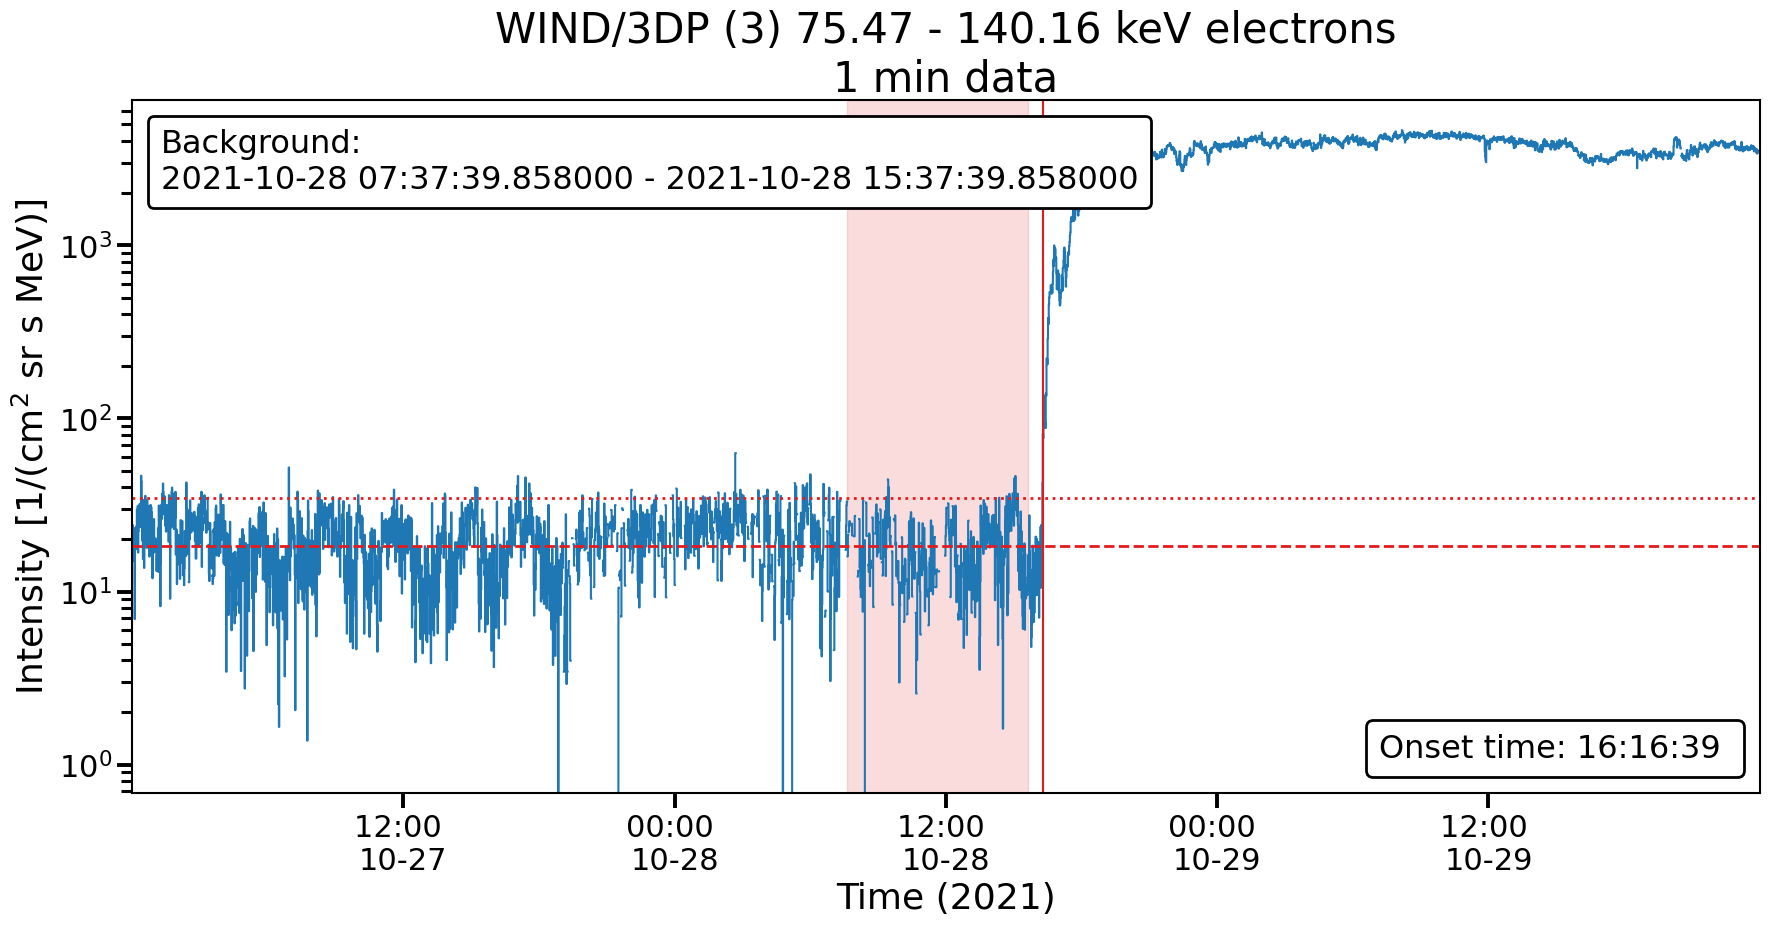

In [ ]:
csv_path = f"{os.getcwd()}{os.sep}wind_events.csv"
with open(csv_path, "+r", encoding="utf-8") as fp:
    event_no = len(fp.readlines())
    for i in range(len(arg_optima) - 1):
        if (data[arg_optima].iloc[i+1] / data[arg_optima].iloc[i] > 10) and (data[arg_optima].iloc[i + 1] > data[arg_optima].iloc[i]):
            bg_end = data[arg_optima].index[i]
            bg_start = bg_end - pd.Timedelta(hours=8)
            background = BootstrapWindow(bg_start, bg_end, bootstraps=1000)
            single_onset_stats, flux_series = onset.cusum_onset(channels=[3], background_range=background, 
                                                                        viewing="3", resample="1min", cusum_minutes=60,
                                                                        plot=True)
            onset_date = single_onset_stats[-1].date()
            onset_time = single_onset_stats[-1].time()
            fp.write(f"{event_no},{onset_date},{onset_time},{bg_start},{bg_end}")

In [ ]:
csv_path = f"{os.getcwd()}{os.sep}wind_events.csv"
with open(csv_path, "+r", encoding="utf-8") as fp:
    event_no = len(fp.readlines())
    

4
